In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

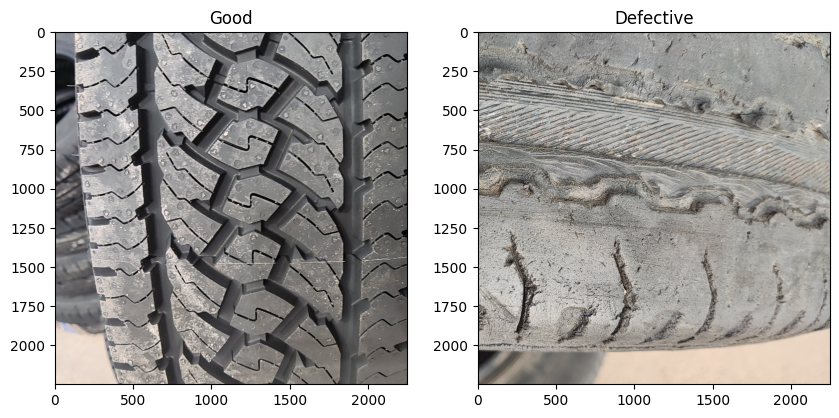

In [ ]:
good_folder = r'Good'
defective_folder = r'Defective'

good_image_path = os.path.join(good_folder, os.listdir(good_folder)[0])
defective_image_path = os.path.join(defective_folder, os.listdir(defective_folder)[0])

good_image = cv2.imread(good_image_path)
defective_image = cv2.imread(defective_image_path)

good_image = cv2.cvtColor(good_image, cv2.COLOR_BGR2RGB)
defective_image = cv2.cvtColor(defective_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(good_image)
plt.title("Good")

plt.subplot(1, 2, 2)
plt.imshow(defective_image)
plt.title("Defective")

plt.show()




### Using ORB to extract some features from the images

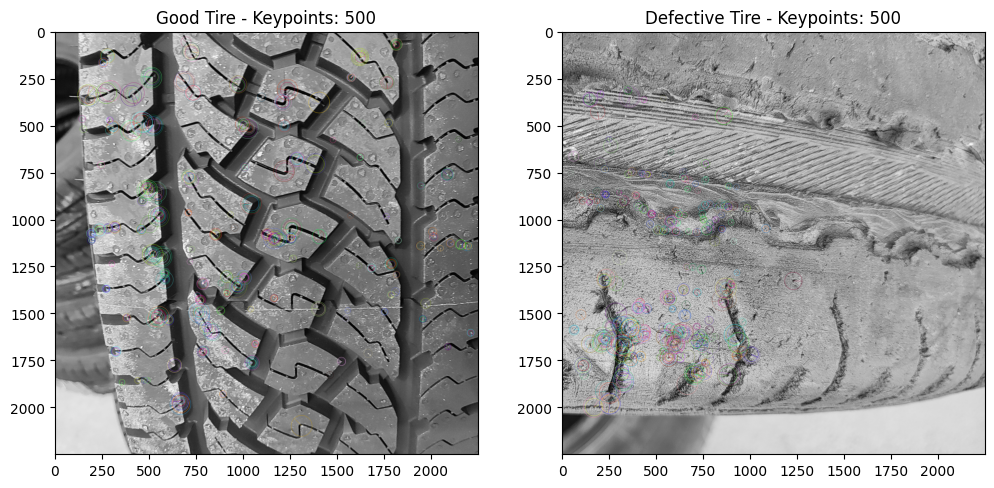

Good Image Descriptors Shape: (500, 32)
Defective Image Descriptors Shape: (500, 32)


In [ ]:
good_image_path = os.path.join(good_folder, os.listdir(good_folder)[0])
defective_image_path = os.path.join(defective_folder, os.listdir(defective_folder)[0])

good_image = cv2.imread(good_image_path, cv2.IMREAD_GRAYSCALE)
defective_image = cv2.imread(defective_image_path, cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints_good, descriptors_good = orb.detectAndCompute(good_image, None)
keypoints_defective, descriptors_defective = orb.detectAndCompute(defective_image, None)

# Draw the keypoints on the images
good_image_with_keypoints = cv2.drawKeypoints(good_image, keypoints_good, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
defective_image_with_keypoints = cv2.drawKeypoints(defective_image, keypoints_defective, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the images with keypoints
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(good_image_with_keypoints, cmap='gray')
plt.title(f"Good Tire - Keypoints: {len(keypoints_good)}")

plt.subplot(1, 2, 2)
plt.imshow(defective_image_with_keypoints, cmap='gray')
plt.title(f"Defective Tire - Keypoints: {len(keypoints_defective)}")

plt.show()

print("Good Image Descriptors Shape:", descriptors_good.shape)
print("Defective Image Descriptors Shape:", descriptors_defective.shape)


In [ ]:
# Check for GPU availability
def check_gpu():
    try:
        import torch
        if torch.cuda.is_available():
            print("GPU is available. Running on:", torch.cuda.get_device_name(0))
        else:
            print("GPU is not available. Running on CPU.")
    except ImportError:
        print("PyTorch is not installed. Please install it to check GPU availability.")

check_gpu()

# Define the folders for the images
good_folder = r'Good'
defective_folder = r'Defective'

# Function to load images from a directory
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(cv2.resize(image, (224, 224))) 
            labels.append(label)
    return images, labels

# Load images and labels
good_images, good_labels = load_images_from_folder(good_folder, label=0)  # 0 for Good
defective_images, defective_labels = load_images_from_folder(defective_folder, label=1)  # 1 for Defective

# Combine the datasets
all_images = np.array(good_images + defective_images)
all_labels = np.array(good_labels + defective_labels)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=10, random_state=42, stratify=y_temp)

# Save the test set separately
test_set = {"images": X_test, "labels": y_test}

# Convert data to arrays for training/validation
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel dimension
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Normalize the pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Save the dataset in Pandas DataFrame format for visualization if needed
df = pd.DataFrame({"Image": list(all_images), "Label": list(all_labels)})

# Display the dataset statistics
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])



GPU is available. Running on: NVIDIA A100-SXM4-40GB
Training set size: 246
Validation set size: 96
Test set size: 10


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 654ms/step - accuracy: 0.5184 - loss: 0.8513 - val_accuracy: 0.8438 - val_loss: 0.4130
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9390 - loss: 0.2409 - val_accuracy: 0.9167 - val_loss: 0.2340
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9666 - loss: 0.1113 - val_accuracy: 0.9167 - val_loss: 0.2199
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9982 - loss: 0.0557 - val_accuracy: 0.9167 - val_loss: 0.2000
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9965 - loss: 0.0380 - val_accuracy: 0.9167 - val_loss: 0.2083
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9991 - loss: 0.0273 - val_accuracy: 0.9167 - val_loss: 0.2174
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.9167 - val_loss: 0.1880
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.9167 - val_loss: 0.206

Test Accuracy: 100.00%


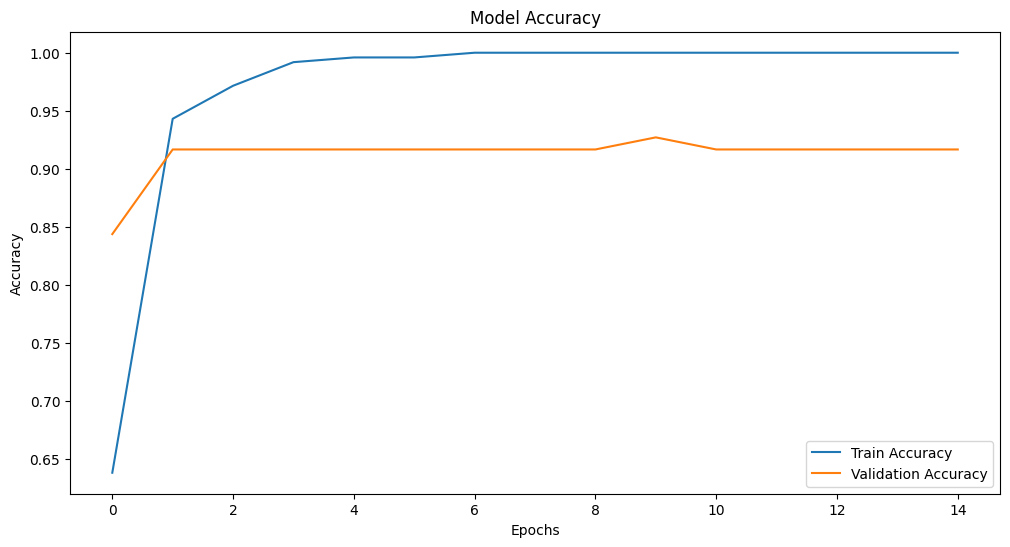

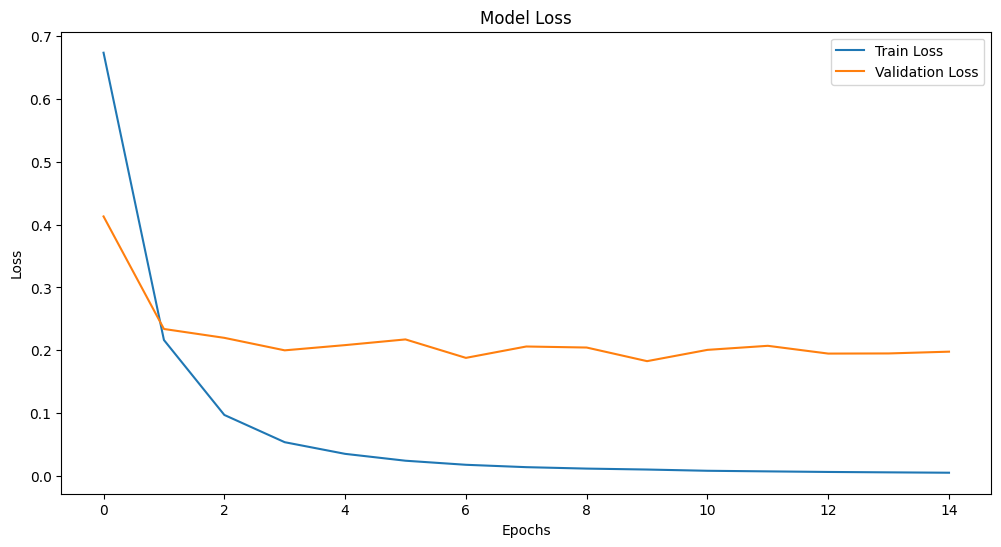

In [13]:
# Expand grayscale images to 3 channels
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Labels to Categorical Classification
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# VGG16
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

# custom classification layers on top of VGG16
x = Flatten()(vgg16_base.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg16_base.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#  early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model train
history = model.fit(
    X_train_rgb, y_train_cat,
    validation_data=(X_val_rgb, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.save("vgg16_tire_classifier.h5")

# Visualizations

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
